# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

The development process follows the instructions on https://github.com/mrdbourke/simple-local-rag


## Requirements and setup

* Local NVIDIA GPU or Google Colab with access to a GPU.
* Data source (for example, a PDF).
* Internet connection (to download the models, but once you have them, it'll run offline).

In [149]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.


## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

This project uses Understanding Deep Learning By Simon J. D. Prince as an example.
https://github.com/udlbook/udlbook/releases/download/v4.0.2/UnderstandingDeepLearning_07_02_24_C.pdf

In [150]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "UnderstandingDeepLearning.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://github.com/udlbook/udlbook/releases/download/v4.0.2/UnderstandingDeepLearning_07_02_24_C.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File UnderstandingDeepLearning.pdf exists.


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [151]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymu pdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 14,  # adjust page numbers since our PDF starts on page 14
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts = pages_and_texts[14:] #delete cover and intro pages

pages_and_texts[0] #Get the first page

0it [00:00, ?it/s]

{'page_number': 0,
 'page_char_count': 2361,
 'page_word_count': 382,
 'page_sentence_count_raw': 20,
 'page_token_count': 590.25,
 'text': 'Chapter 1 Introduction Artificial intelligence, or AI, is concerned with building systems that simulate intelligent behavior. It encompasses a wide range of approaches, including those based on logic, search, and probabilistic reasoning. Machine learning is a subset of AI that learns to make decisions by fitting mathematical models to observed data. This area has seen explosive growth and is now (incorrectly) almost synonymous with the term AI. A deep neural network is a type of machine learning model, and when it is fitted to data, this is referred to as deep learning. At the time of writing, deep networks are the most powerful and practical machine learning models and are often encountered in day-to-day life. It is commonplace to translate text from another language using a natural language processing algorithm, to search the internet for images

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.



In [152]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,2361,382,20,590.25,Chapter 1 Introduction Artificial intelligence...
1,1,2711,459,26,677.75,2 1 Introduction Figure 1.1 Machine learning i...
2,2,704,107,7,176.00,1.1 Supervised learning 3 Figure 1.2 Regressio...
3,3,2071,349,20,517.75,4 1 Introduction Figure 1.3 Machine learning m...
4,4,3150,516,24,787.50,1.1 Supervised learning 5 model is a mathemati...


In [153]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,527.00,527.00,527.00,527.00,527.00
mean,263.00,2440.98,394.39,27.98,610.25
std,152.28,1061.67,154.97,28.24,265.42
min,0.00,0.00,1.00,1.00,0.00
25%,131.50,1665.00,282.50,14.00,416.25
50%,263.00,2231.00,369.00,20.00,557.75
75%,394.50,3084.00,487.50,27.00,771.00
max,526.00,4809.00,752.00,128.00,1202.25


The average token count per page is 610.25.

For this case, it means we cannot not embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

To faciliate word embedding, we need to split the original pages into chunks following the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

We will use a natural language processing (NLP) library to split paragraphs into sentences, such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

In [154]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [155]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/527 [00:00<?, ?it/s]

In [156]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 81,
  'page_char_count': 738,
  'page_word_count': 125,
  'page_sentence_count_raw': 9,
  'page_token_count': 184.5,
  'text': '82 6 Fitting models Figure 6.4 Loss function for the Gabor model. a) The loss function is non-convex, with multiple local minima (cyan circles) in addition to the global minimum (gray circle). It also contains saddle points where the gradient is locally zero, but the function increases in one direction and decreases in the other. The blue cross is an example of a saddle point; the function decreases as we move horizontally in either direction but increases as we move vertically. b–f) Models associated with the different minima. In each case, there is no small change that decreases the loss. Panel (c) shows the global minimum, which has a loss of 0.64. This work is subject to a Creative Commons CC-BY-NC-ND license. (C) MIT Press.',
  'sentences': ['82 6 Fitting models Figure 6.4 Loss function for the Gabor model.',
   'a) The loss function is n

Now let's turn out list of dictionaries into a DataFrame and get some stats. We can find that each page has a average of 25.34 sentences.

In [157]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,527.00,527.00,527.00,527.00,527.00,527.00
mean,263.00,2440.98,394.39,27.98,610.25,25.34
std,152.28,1061.67,154.97,28.24,265.42,20.13
min,0.00,0.00,1.00,1.00,0.00,0.00
25%,131.50,1665.00,282.50,14.00,416.25,13.00
50%,263.00,2231.00,369.00,20.00,557.75,19.00
75%,394.50,3084.00,487.50,27.00,771.00,28.00
max,526.00,4809.00,752.00,128.00,1202.25,90.00


### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

We're going to break our pages of sentences into chunks of 10 sentences to meet our embedding model capacity of 384.

In [158]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/527 [00:00<?, ?it/s]

In [159]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 502,
  'page_char_count': 4387,
  'page_word_count': 656,
  'page_sentence_count_raw': 105,
  'page_token_count': 1096.75,
  'text': 'Bibliography 503 segmentation on 2D images. Applied Artificial Intelligence, 36(1). 184 Ulyanov, D., Vedaldi, A., & Lempitsky, V. (2016). Instance normalization: The missing ingredi- ent for fast stylization. arXiv:1607.08022. 203 Ulyanov, D., Vedaldi, A., & Lempitsky, V. (2018). Deep image prior. IEEE/CVF Computer Vi- sion & Pattern Recognition, 9446–9454. 418 Urban, G., Geras, K. J., Kahou, S. E., Aslan, O., Wang, S., Caruana, R., Mohamed, A., Phili- pose, M., & Richardson, M. (2017). Do deep convolutional nets really need to be deep and convolutional? International Conference on Learning Representations. 417, 418 Vahdat, A., Andriyash, E., & Macready, W. (2018a). DVAE#: Discrete variational autoen- coders with relaxed Boltzmann priors. Neu- ral Information Processing Systems, 31, 1869– 1878. 344 Vahdat, A., Andriyash, E., & Macready, 

In [160]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,527.00,527.00,527.00,527.00,527.00,527.00,527.00
mean,263.00,2440.98,394.39,27.98,610.25,25.34,3.00
std,152.28,1061.67,154.97,28.24,265.42,20.13,2.01
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,131.50,1665.00,282.50,14.00,416.25,13.00,2.00
50%,263.00,2231.00,369.00,20.00,557.75,19.00,2.00
75%,394.50,3084.00,487.50,27.00,771.00,28.00,3.00
max,526.00,4809.00,752.00,128.00,1202.25,90.00,9.00


Note the average number of chunks is around 3, which means each page was split into 3 chunks on average.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [161]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/527 [00:00<?, ?it/s]

1581

In [162]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 476,
  'sentence_chunk': 'PixelVAE: A latent variable model for natural images. International Conference on Learning Representations.299, 343, 344, 345 Ha, D., Dai, A., & Le, Q. V. (2017). Hypernet- works. International Conference on Learning Representations.235 Haarnoja, T., Hartikainen, K., Abbeel, P., & Levine, S. (2018a). Latent space policies for hierarchical reinforcement learning. Interna- tional Conference on Machine Learning, 1851– 1860.322 Haarnoja, T., Zhou, A., Abbeel, P., & Levine, S. (2018b). Soft actor-critic: Off-policy maxi- mum entropy deep reinforcement learning with a stochastic actor.',
  'chunk_char_count': 586,
  'chunk_word_count': 80,
  'chunk_token_count': 146.5}]

In [163]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1581.00,1581.00,1581.00,1581.00
mean,300.31,811.16,129.63,202.79
std,157.06,430.47,74.31,107.62
min,0.00,13.00,3.00,3.25
25%,169.00,526.00,76.00,131.50
50%,312.00,738.00,116.00,184.50
75%,463.00,1102.00,179.00,275.50
max,526.00,2577.00,436.00,644.25


The chunks seem to have a satisfactory token count on average(202.79).

But there are some chunks with extreme low or high token counts. The former may not provide valuable info, and the later does not meet the requirement for our embedding model. So we will simply delete them.

In [164]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 19.5 | Text: This work is subject to a Creative Commons CC-BY-NC-ND license. (C) MIT Press.
Chunk token count: 3.25 | Text: C) MIT Press.
Chunk token count: 12.75 | Text: Draft: please send errata to udlbookmail@gmail.com.
Chunk token count: 17.0 | Text: Then the decoder Draft: please send errata to udlbookmail@gmail.com.
Chunk token count: 3.25 | Text: C) MIT Press.


In [165]:
# Show random chunks with over 350 tokens in length
max_token_length = 350
for row in df[df["chunk_token_count"] >= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 48.75 | Text: If the number of columns D2 of the matrix is fewer than the number of rows D1 (i.e., the matrix is “portrait”), the product Ax cannot reach all Draft: please send errata to udlbookmail@gmail.com.
Chunk token count: 167.5 | Text: In one case, the latent variable is drawn from the latent posterior distribution and, in the other, from the prior. Other hybrids of VAEs and GANs were proposed by Larsen et al. (2016), Brock et al. (2016), and Hsu et al. (2017a). Posterior collapse: One potential problem in training is posterior collapse, in which the encoder always predicts the prior distribution. This was identified by Bowman et al. (2015) and can be mitigated by gradually increasing the term that encourages the KL distance between the posterior and the prior to be small during training. Several other methods have been proposed to prevent posterior collapse (Razavi et al.,2019a; Lucas et al.,
Chunk token count: 193.0 | Text: Combining these methods produces i

In [166]:
pages_and_chunks_fix_token_len = df[df["chunk_token_count"] > min_token_length]
pages_and_chunks_fix_token_len = pages_and_chunks_fix_token_len[pages_and_chunks_fix_token_len["chunk_token_count"] < max_token_length].to_dict(orient="records")
pages_and_chunks_fix_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': 'Chapter 1 Introduction Artificial intelligence, or AI, is concerned with building systems that simulate intelligent behavior. It encompasses a wide range of approaches, including those based on logic, search, and probabilistic reasoning. Machine learning is a subset of AI that learns to make decisions by fitting mathematical models to observed data. This area has seen explosive growth and is now (incorrectly) almost synonymous with the term AI. A deep neural network is a type of machine learning model, and when it is fitted to data, this is referred to as deep learning. At the time of writing, deep networks are the most powerful and practical machine learning models and are often encountered in day-to-day life. It is commonplace to translate text from another language using a natural language processing algorithm, to search the internet for images of a particular object using a computer vision system, or to converse with a digital assistant via 

In [167]:
len(pages_and_chunks_fix_token_len)

1382

### Embedding our text chunks

Our goal is to turn each of our chunks into a numerical representation. The embedding vectors are for our computers to understand.

Specifically, we'll get the `all-mpnet-base-v2` model(https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses).

In [168]:
%%time
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_fix_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1382 [00:00<?, ?it/s]

CPU times: user 32.9 s, sys: 594 ms, total: 33.5 s
Wall time: 45.9 s


### Save embeddings to file

Since creating embeddings can be a timely process, let's turn our `pages_and_chunks_fix_token_len` list of dictionaries into a DataFrame and save it.

In [169]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_fix_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False, escapechar='\\')

And we can make sure it imports nicely by loading it.

In [170]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,Chapter 1 Introduction Artificial intelligence...,1281,205,320.25,[ 1.82628515e-03 1.37184625e-02 -3.36784981e-...
1,0,The goal is to explain the underlying ideas; a...,1078,176,269.50,[ 3.61241214e-02 9.93499532e-02 -4.44032699e-...
2,1,2 1 Introduction Figure 1.1 Machine learning i...,990,161,247.50,[-4.20787558e-02 4.21708263e-02 -5.63775562e-...
3,1,This is a regression problem because the model...,1006,170,251.50,[ 3.53948027e-02 -4.48206514e-02 -2.12890450e-...
4,1,"In each case, the model returns a vector of si...",710,125,177.50,[ 2.44565178e-02 6.95272116e-04 -1.70633160e-...


In [171]:
chunk_number = len(text_chunks_and_embedding_df_load["embedding"])
print(f"chunk number: {chunk_number}")

chunk number: 1382


## 2. RAG - Search and Answer

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

### Similarity search

We will use cosine similarity for search.

In [172]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1382, 768])

In [173]:
from sentence_transformers import util
# 1. Define the query
# Note: This could be anything about the book.
query = "What is a decision tree model?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: What is a decision tree model?


torch.return_types.topk(
values=tensor([0.4375, 0.4156, 0.4040, 0.3952, 0.3669], device='cuda:0'),
indices=tensor([ 8, 43, 42,  3, 44], device='cuda:0'))

In [174]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

In [175]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What is a decision tree model?'

Results:
Score: 0.4375
Text:
1.1 Supervised learning 5 model is a mathematical equation that describes how
the average height varies as a function of age (cyan curve in figure 1.3). When
we run the age through this equation, it returns the height. For example, if the
age is 10 years, then we predict that the height will be 139 cm. More precisely,
the model represents a family of equations mapping the input to the output
(i.e., a family of different cyan curves). The particular equation (curve) is
chosen using training data (examples of input/output pairs). In figure 1.3,
these pairs are represented by the orange points, and we can see that the model
(cyan line) describes these data reasonably. When we talk about training or
fitting a model, we mean that we search through the family of possible equations
(possible cyan curves) relating input to output to find the one that describes
the training data most accurately. It follows that the models in 

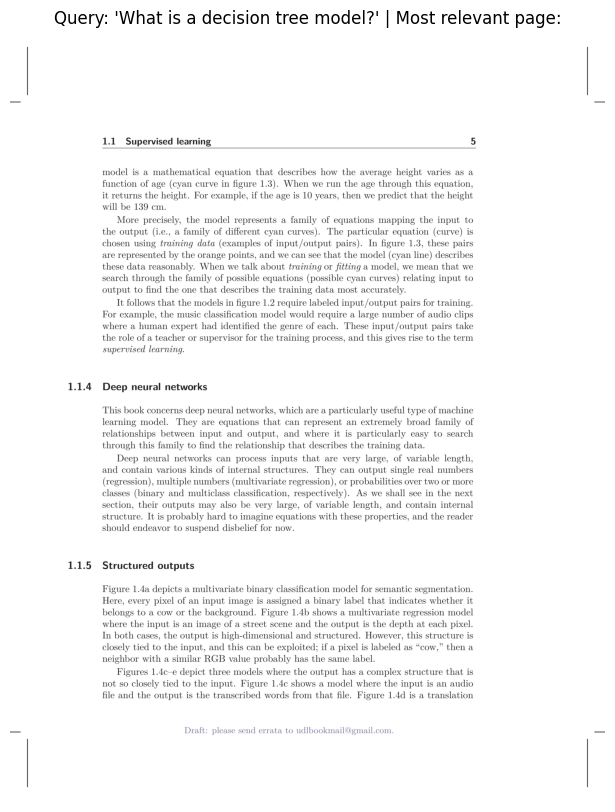

In [176]:
import fitz

# Open PDF and load target page
pdf_path = "UnderstandingDeepLearning.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(14 + 4) # number of page (our doc starts page numbers on page 14)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [177]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    dot_scores = util.dot_score(query_embedding, embeddings)[0]


    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [178]:
query = "What is deep learning?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

(tensor([0.6621, 0.6263, 0.5828, 0.5825, 0.5825], device='cuda:0'),
 tensor([   0,   39,  208,  891, 1101], device='cuda:0'))

In [179]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Query: What is deep learning?

Results:
Score: 0.6621
Chapter 1 Introduction Artificial intelligence, or AI, is concerned with
building systems that simulate intelligent behavior. It encompasses a wide range
of approaches, including those based on logic, search, and probabilistic
reasoning. Machine learning is a subset of AI that learns to make decisions by
fitting mathematical models to observed data. This area has seen explosive
growth and is now (incorrectly) almost synonymous with the term AI. A deep
neural network is a type of machine learning model, and when it is fitted to
data, this is referred to as deep learning. At the time of writing, deep
networks are the most powerful and practical machine learning models and are
often encountered in day-to-day life. It is commonplace to translate text from
another language using a natural language processing algorithm, to search the
internet for images of a particular object using a computer vision system, or to
converse with a digital a

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM). In this case, we use open-source Gemma-2b-it as an example. (https://huggingface.co/google/gemma-2b-it)



### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

In [180]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [181]:
!nvidia-smi

Sat Jul 20 03:30:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              32W /  70W |   9845MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [182]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally

We will use the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library to perform our tasks.

In [183]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN') #set your own Hugging Face Token here

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# !pip install bitsandbytes
# For models that require 4-bit quantization (use this if you have low GPU memory available)
# from transformers import BitsAndBytesConfig
# quantization_config = BitsAndBytesConfig(load_in_4bit=True,
#                                          bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
!pip install flash-attn
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id,
                                          token=HF_TOKEN)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation,
                                                 token=HF_TOKEN) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [184]:
# check the LLM model
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

The `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning). In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.


In [185]:
input_text = "What is deep learning?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is deep learning?

Prompt (formatted):
<bos><start_of_turn>user
What is deep learning?<end_of_turn>
<start_of_turn>model



Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

We'll make sure our tokenized text is on the same device as our model (GPU) using `to("cuda")`.

In [186]:
# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=500) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,   5271,   6044,
         235336,    107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,   5271,   6044,
        235336,    107,    108,    106,   2516,    108,    688,  26843,   6044,
           688,    603,    476,   1334,   2863,    576,   6479,   6044,    674,
         31381,    611, 229728,    573,   5449,    578,   1411,    576,    573,
          3515,   9494, 235265,   1165,  18348,    573,   3505,    576,  28514,
           674,    798,   3918,    774,   1423,   2346,  19303,  19991, 235265,
           109,    688,   2469,  54737,    576,  20555,  14715,  66058,    109,
        235287,   5231, 105460,  57663,  37541,    591,  18732, 235256,   1245,
           688,  85856,    731,    573,   5449,

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [187]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is deep learning?<end_of_turn>
<start_of_turn>model
**Deep learning** is a subfield of machine learning that focuses on mimicking the structure and function of the human brain. It involves the development of algorithms that can learn from data without explicit programming.

**Key Concepts of Deep Learning:**

* **Artificial Neural Networks (ANNs):** Inspired by the structure and function of the human brain, ANNs are composed of interconnected nodes or "neurons" that process and transmit information.
* **Supervised Learning:** In supervised learning, algorithms are trained on labeled data, where each data point is associated with a known outcome. The algorithm learns to map the input data to the corresponding output.
* **Unsupervised Learning:** In unsupervised learning, algorithms discover patterns and relationships in unlabeled data without explicit guidance.
* **Deep Learning Architectures:** Deep learning models often employ

`"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively. We can remove them.

In [188]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is deep learning?

Output text:
**Deep learning** is a subfield of machine learning that focuses on mimicking the structure and function of the human brain. It involves the development of algorithms that can learn from data without explicit programming.

**Key Concepts of Deep Learning:**

* **Artificial Neural Networks (ANNs):** Inspired by the structure and function of the human brain, ANNs are composed of interconnected nodes or "neurons" that process and transmit information.
* **Supervised Learning:** In supervised learning, algorithms are trained on labeled data, where each data point is associated with a known outcome. The algorithm learns to map the input data to the corresponding output.
* **Unsupervised Learning:** In unsupervised learning, algorithms discover patterns and relationships in unlabeled data without explicit guidance.
* **Deep Learning Architectures:** Deep learning models often employ deep neural networks with multiple layers, which are stacked 

How cool is that!

We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [189]:
# Deep learning questions generated with chatgpt
query_list = [
    "What is deep learning?",
    "What are activation functions?",
    "What is a convolutional neural network?",
    "How can overfitting be prevented?",
    "How can I tune hyperparameters in deep learning?"
]


In [190]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What is deep learning?


(tensor([0.6621, 0.6263, 0.5828, 0.5825, 0.5825], device='cuda:0'),
 tensor([   0,   39,  208,  891, 1101], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In [191]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """With the following context items as part of your knowledge, please answer the query.
Don't return the thinking, only return the answer to the query.
Make sure your answers are as explanatory as possible.
\nContext items:
{context}
\n
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [192]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How can I tune hyperparameters in deep learning?
<bos><start_of_turn>user
With the following context items as part of your knowledge, please answer the query.
Don't return the thinking, only return the answer to the query.
Make sure your answers are as explanatory as possible.

Context items:
- 8.6 Summary 133 Hyperparameters are typically chosen empirically; we train many models with differ- ent hyperparameters on the same training set, measure their performance, and retain the best model. However, we do not measure their performance on the test set; this would admit the possibility that these hyperparameters just happen to work well for the test set but don’t generalize to further data. Instead, we introduce a third dataset known as a validation set. For every choice of hyperparameters, we train the associated model using the training set and evaluate performance on the validation set. Finally, we select the model that worked best on the validation set and measure its performa

After finishing the prompt, we can tokenize this and pass it straight to our LLM.

In [193]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.3, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=500) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How can I tune hyperparameters in deep learning?
RAG answer:
<bos>Sure, here's an answer to the user's query:

Hyperparameter search is a process of finding the best set of hyperparameters for a deep learning model. These hyperparameters can include the number of hidden layers, the number of hidden units in each layer, the learning rate, and the batch size.

To tune hyperparameters, it is important to use a variety of techniques, such as grid search, random search, and Bayesian optimization. These techniques can help to find the best set of hyperparameters that will lead to the best possible performance on the task.<eos>


Create a function to include all the sub-tasks.

In [194]:
def ask(query,
        temperature=0.3,
        max_new_tokens=500,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [195]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.3,
                            max_new_tokens=500,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
for i, item in enumerate(context_items):
  context = item["sentence_chunk"]
  print(f"{i+1}: {context}")
  print(f"Score: {item['score']}")

Query: What is a convolutional neural network?
Answer:

A convolutional neural network is a specialized type of neural network designed
for processing data that lies on a regular grid. It is particularly suited to
processing images, which have a very large number of input variables, precluding
the use of fully connected networks. Each layer of a convolutional network
employs parameter sharing so that local image patches are processed similarly at
every position in the image.
Context items:
1: Chapter 10 Convolutional networks Chapters 2–9 introduced the supervised learning pipeline for deep neural networks. How- ever, these chapters only considered fully connected networks with a single path from input to output. Chapters 10–13 introduce more specialized network components with sparser connections, shared weights, and parallel processing paths. This chapter de- scribes convolutional layers, which are mainly used for processing image data. Images have three properties that suggest the n

Local RAG workflow is completed! But lots of future improvement can be done, such as trying different LLMs, another prompt, better word embedding, another similarity measure, etc.